## Train EfficientNetV2 on CIFAR-10


In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import os


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\Ernest/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:02<00:00, 36.4MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

EPOCHS = 20
PATIENCE = 2

train_accs, test_accs = [], []
train_losses, test_losses = [], []
best_acc = 0.0
wait = 0
best_model = model.state_dict()


In [6]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total, loss_sum / len(dataloader)


In [7]:
for epoch in range(EPOCHS):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    train_acc = 100. * correct / total
    train_loss = running_loss / len(train_loader)
    test_acc, test_loss = evaluate(model, test_loader, criterion)

    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model.state_dict()
        wait = 0
        torch.save(best_model, "efficientnetv2_best.pth")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 1/20: 100%|██████████| 1563/1563 [06:41<00:00,  3.89it/s, acc=91.8, loss=0.0256]


Train Acc: 91.84%, Test Acc: 96.62%, Train Loss: 0.2638, Test Loss: 0.0981


Epoch 2/20: 100%|██████████| 1563/1563 [06:35<00:00,  3.95it/s, acc=97.4, loss=0.33]   


Train Acc: 97.38%, Test Acc: 96.88%, Train Loss: 0.0808, Test Loss: 0.1023


Epoch 3/20: 100%|██████████| 1563/1563 [06:38<00:00,  3.92it/s, acc=98.2, loss=0.139]   


Train Acc: 98.21%, Test Acc: 96.95%, Train Loss: 0.0544, Test Loss: 0.1038


Epoch 4/20: 100%|██████████| 1563/1563 [06:39<00:00,  3.91it/s, acc=98.6, loss=0.266]  


Train Acc: 98.61%, Test Acc: 96.68%, Train Loss: 0.0438, Test Loss: 0.1111


Epoch 5/20: 100%|██████████| 1563/1563 [06:27<00:00,  4.03it/s, acc=98.8, loss=0.081]   


Train Acc: 98.85%, Test Acc: 96.74%, Train Loss: 0.0364, Test Loss: 0.1216
Early stopping triggered.


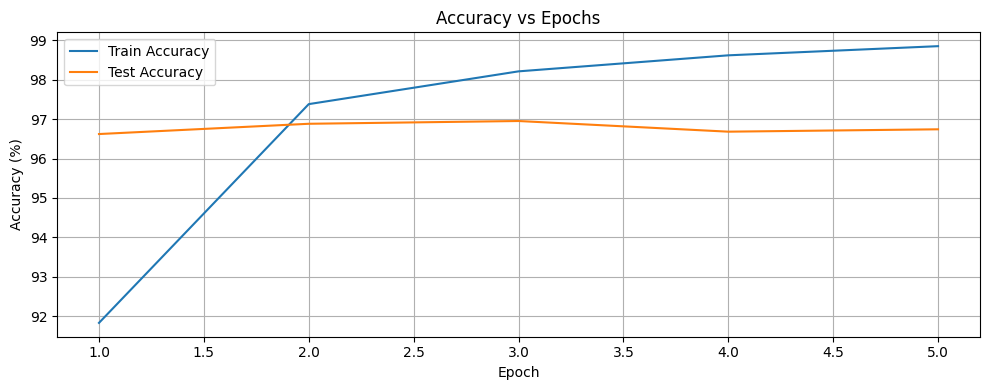

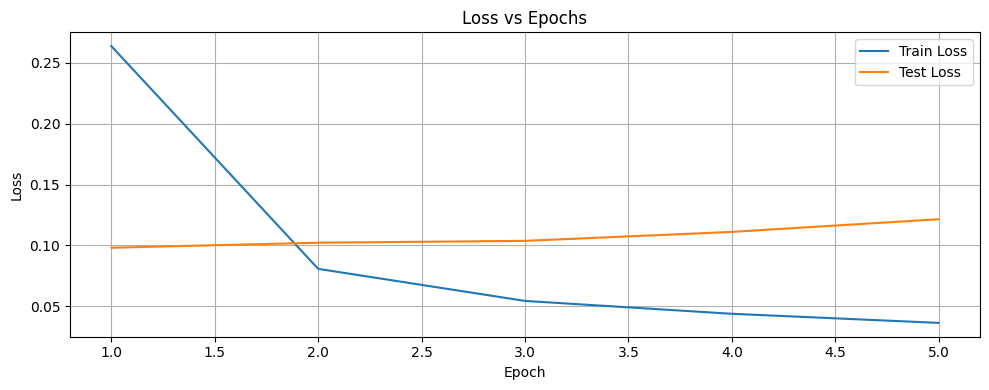

In [8]:
epochs = list(range(1, len(train_accs) + 1))

plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot.png")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot.png")
plt.show()


In [9]:
stats = {
    "epochs": epochs,
    "train_accs": train_accs,
    "test_accs": test_accs,
    "train_losses": train_losses,
    "test_losses": test_losses
}
with open("training_stats.pkl", "wb") as f:
    pickle.dump(stats, f)
